In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, ttest_ind
from Architectures.AE import AE1
from sklearn.preprocessing import StandardScaler
from glob import glob
from tqdm import tqdm

In [3]:
all_latent = []
for fp in tqdm(glob("Data/Latent projections/*.npy"), "Loading latent spaces"):
    # print(fp)
    with open(fp,"br") as f:
        all_latent.append(np.load(f))
print(all_latent[0].shape)

Loading latent spaces: 100%|██████████| 16/16 [00:00<00:00, 76.60it/s]

(2000, 10)


The latent spaces above come from the compare_models.ipynb notebook.

Refer to that notebook if you haven't calculated the latent spaces yet.

In [6]:
# Scale the spaces
all_latent_scaled = [StandardScaler().fit_transform(latent) for latent in all_latent]

C:\Users\PieHu\AppData\Local\Temp\ipykernel_66012\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


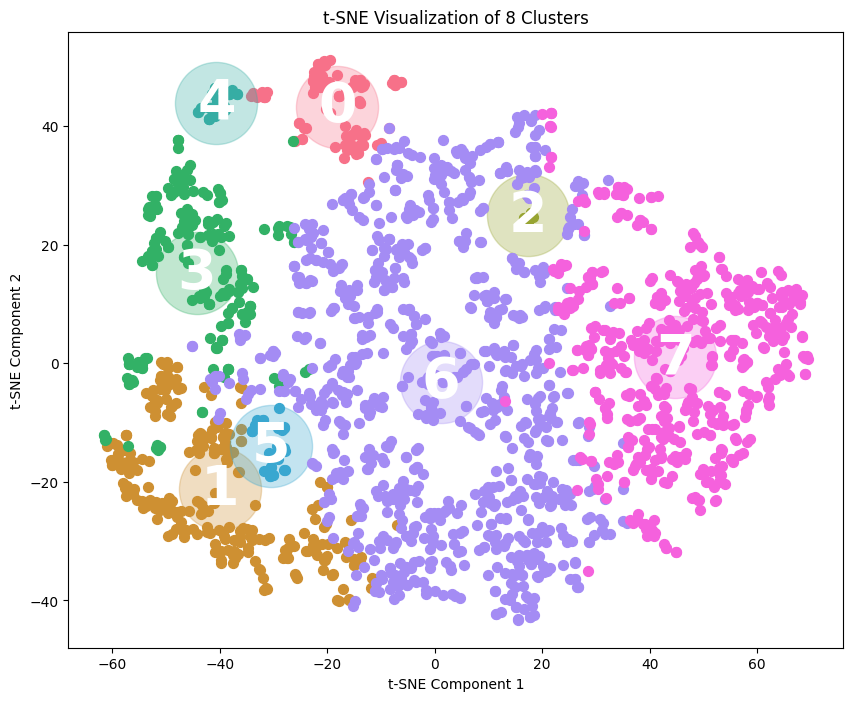

C:\Users\PieHu\AppData\Local\Temp\ipykernel_66012\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


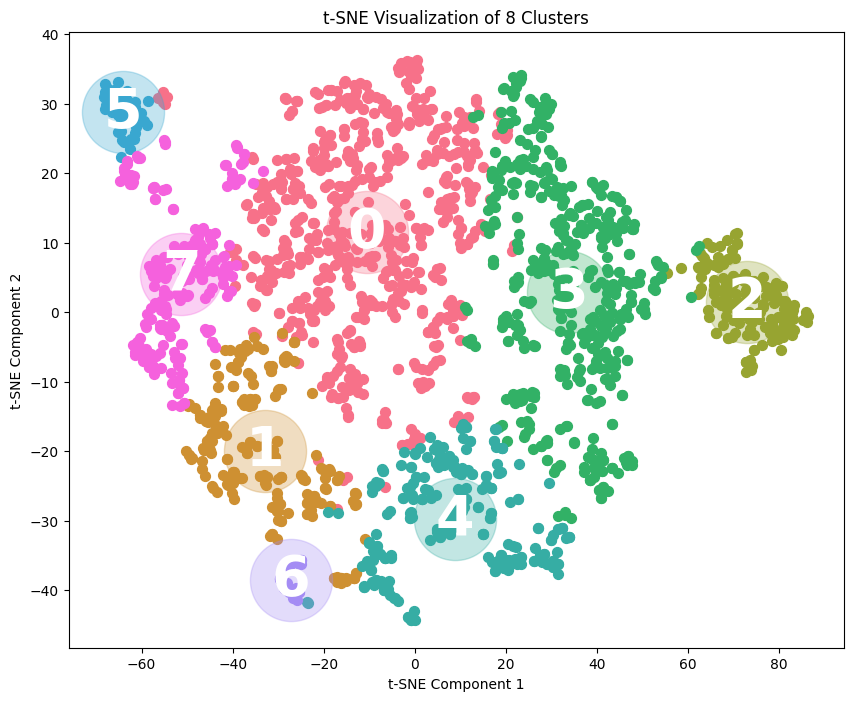

In [306]:
def find_clusters(data, n_clusters=3):
    """
    Perform clustering on MRI latent space data and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples, p-values for clusters.
    """
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    # # Calculate p-values for clusters using t-test (pairwise comparisons)
    # p_values_clusters = np.ones((n_clusters, n_clusters))
    # for i in range(n_clusters):
    #     for j in range(i+1, n_clusters):
    #         t_stat, p_value = ttest_ind(data[labels == i], data[labels == j], equal_var=False)
    #         print(p_value)
    #         p_values_clusters[i, j] = p_value
    #         p_values_clusters[j, i] = p_value
    
    return labels, np.array(p_values_samples)#, p_values_clusters

from sklearn.cluster import SpectralClustering
from scipy.stats import f_oneway
import numpy as np

def find_clusters(data, n_clusters=3):
    """
    Perform clustering on MRI latent space data using Spectral Clustering and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples.
    """
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    return labels, np.array(p_values_samples)



def plot_clusters(data, labels, n_clusters=3, title='t-SNE Visualization of Clusters'):
    """
    Plot the clusters using t-SNE for 2D visualization.

    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    labels (numpy.ndarray): Cluster labels for each sample.
    n_clusters (int): Number of clusters.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)

    # Calculate cluster means
    cluster_means = np.array([data_2d[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Plot using seaborn for better aesthetics
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette('husl', n_clusters)
    
    for i in range(n_clusters):
        # Plot cluster mean with a semi-transparent bubble
        plt.scatter(cluster_means[i, 0], cluster_means[i, 1], color=palette[i], s=3500, alpha=0.3)
        
        # Display cluster ID in white
        plt.text(cluster_means[i, 0], cluster_means[i, 1], str(i), color='white',
                 fontsize=40, ha='center', va='center', fontweight='bold')
        
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], label=f'Cluster {i}', color=palette[i], s=50)

    # plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

for latent_scaled in all_latent_scaled[:2]:
    for n_clusters in [8]: # 4, 8, 12
        labels, p_values_samples = find_clusters(latent_scaled, n_clusters=n_clusters)
        plot_clusters(latent_scaled, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters')


C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


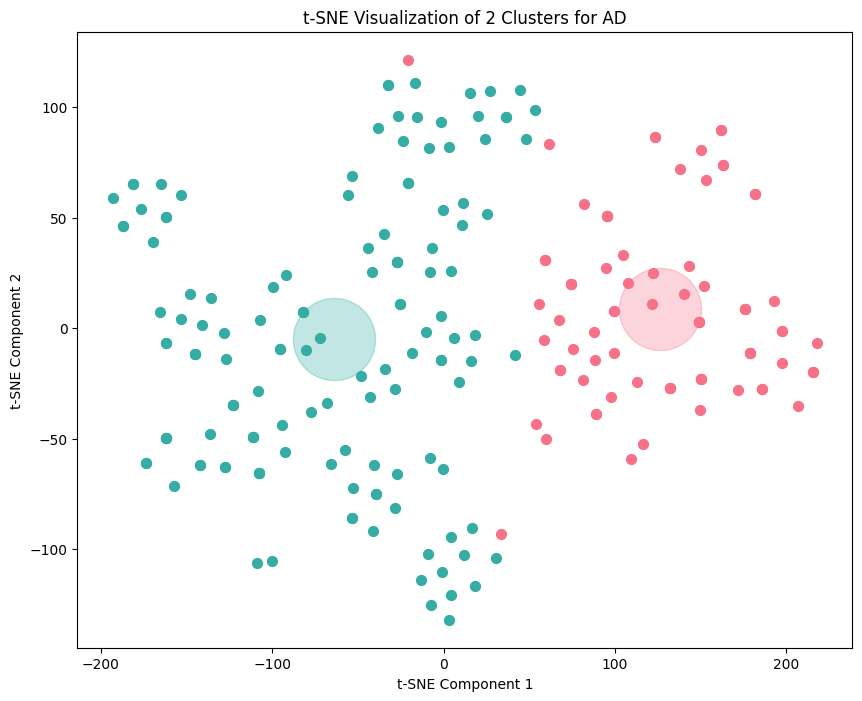

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


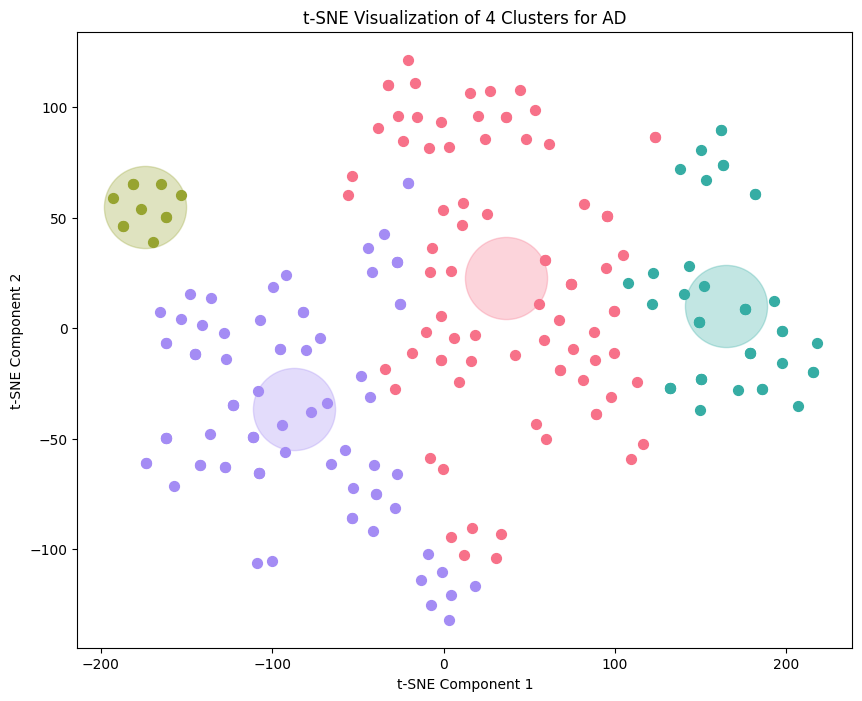

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


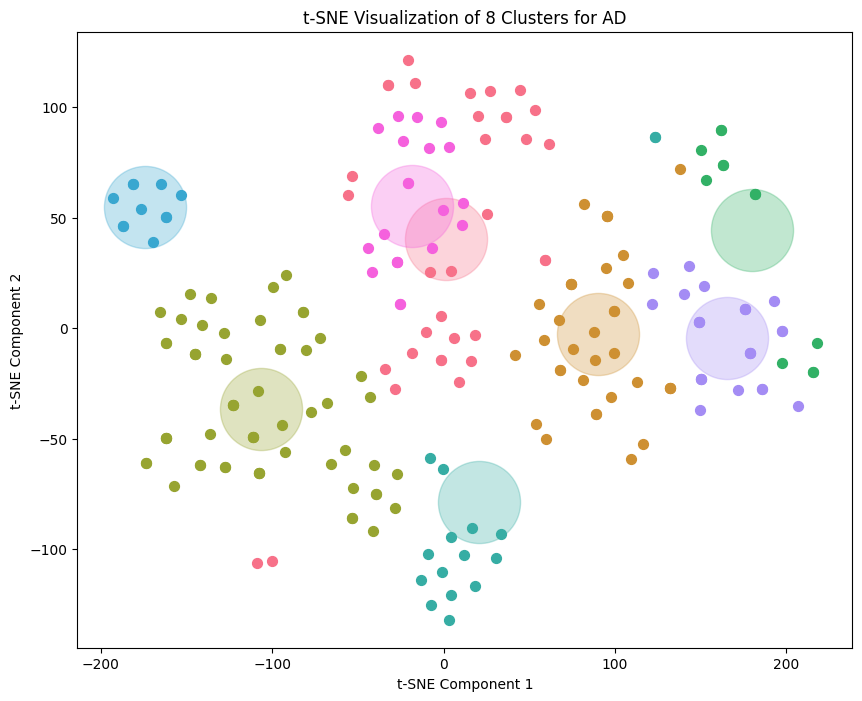

In [ ]:
group = "AD"
group_latent = latent_scaled[1787 : 2000]
for n_clusters in [2, 4, 8]:
    labels, p_values_samples = find_clusters(group_latent, n_clusters=n_clusters)
    plot_clusters(group_latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters for {group}')

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


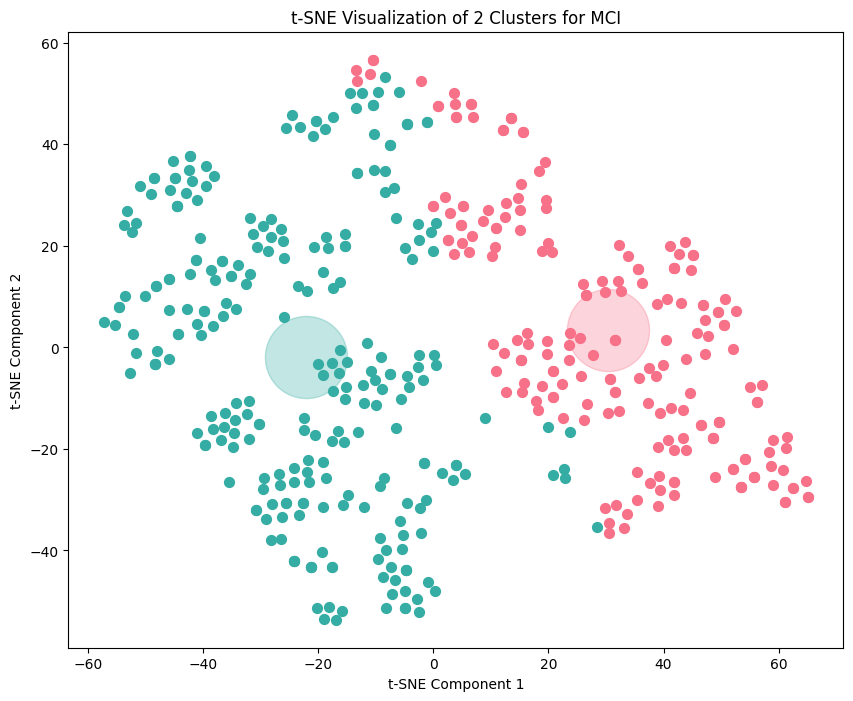

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


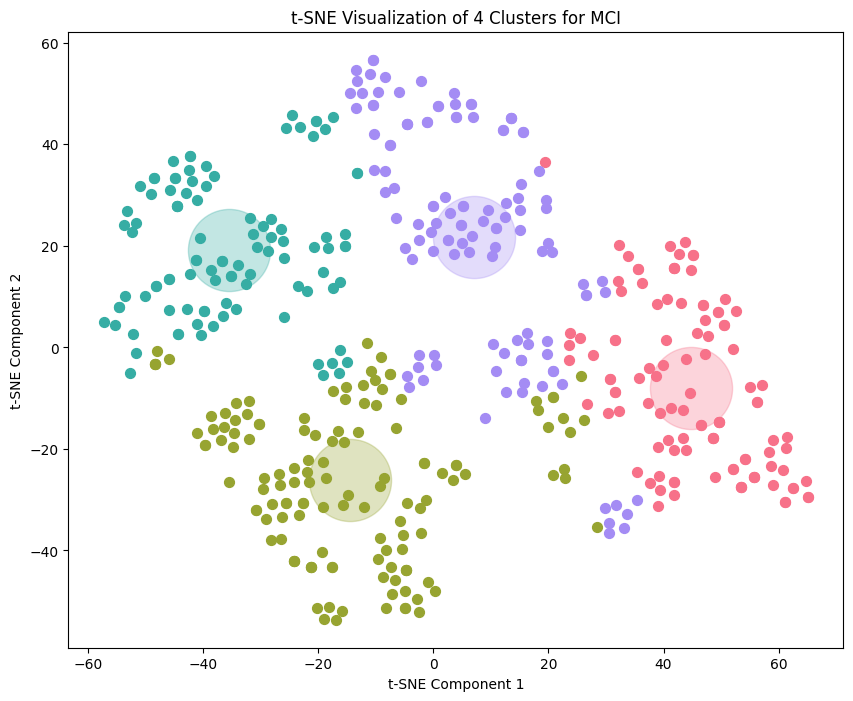

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\4219218166.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


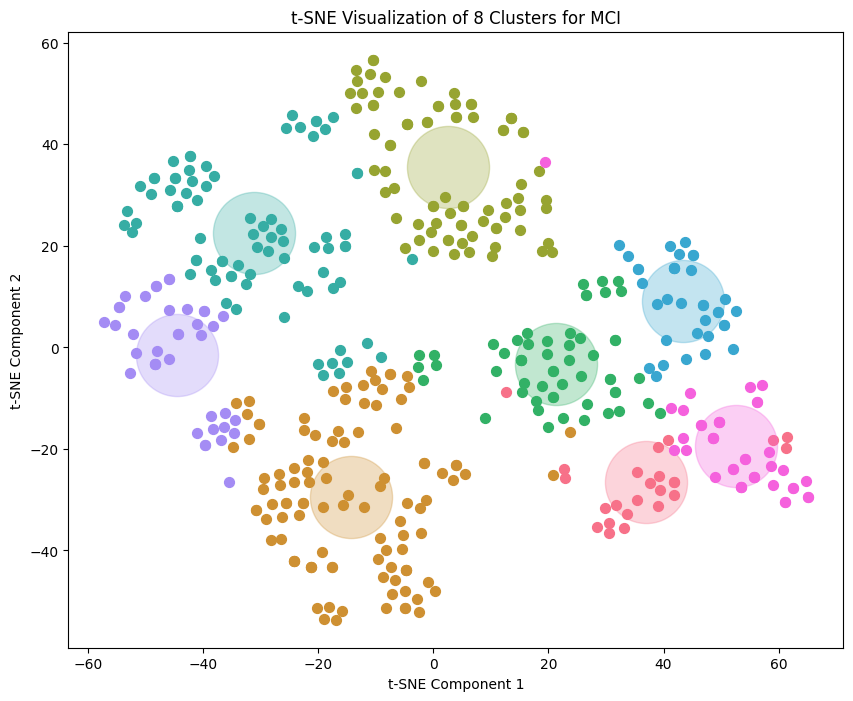

In [ ]:
group = "MCI"
group_latent = latent_scaled[1326 : 1787]
for n_clusters in [2, 4, 8]:
    labels, p_values_samples = find_clusters(group_latent, n_clusters=n_clusters)
    plot_clusters(group_latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters for {group}')

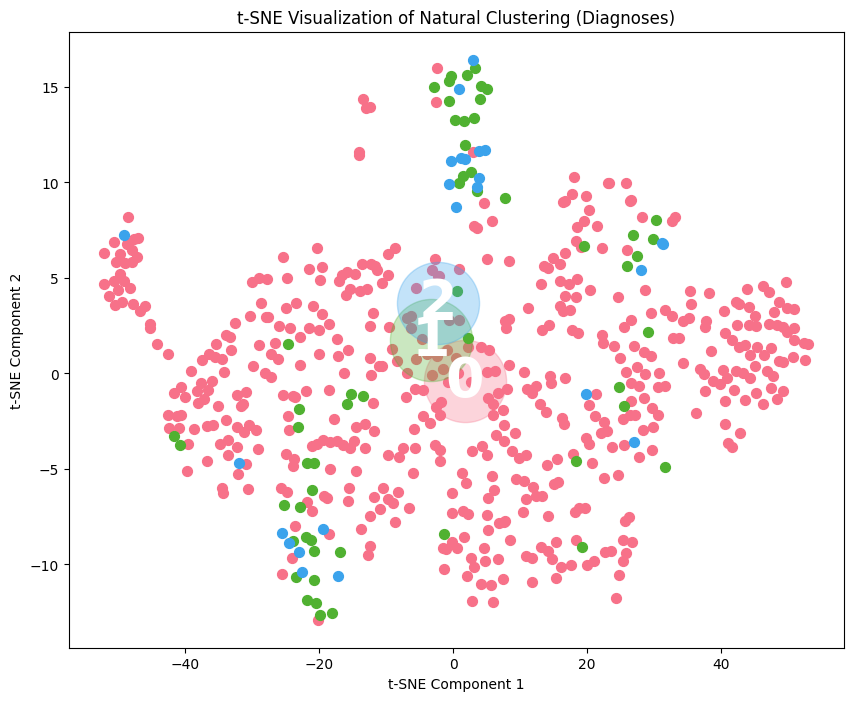

In [ ]:
labels_nat = np.zeros(len(latent_scaled))
labels_nat[1326 : 1787]=1
labels_nat[1787 : 2000]=2
plot_clusters(latent_scaled[all_subjects["Group"]!=0], labels_nat[all_subjects["Group"]!=0], n_clusters=3,title='t-SNE Visualization of Natural Clustering (Diagnoses)')

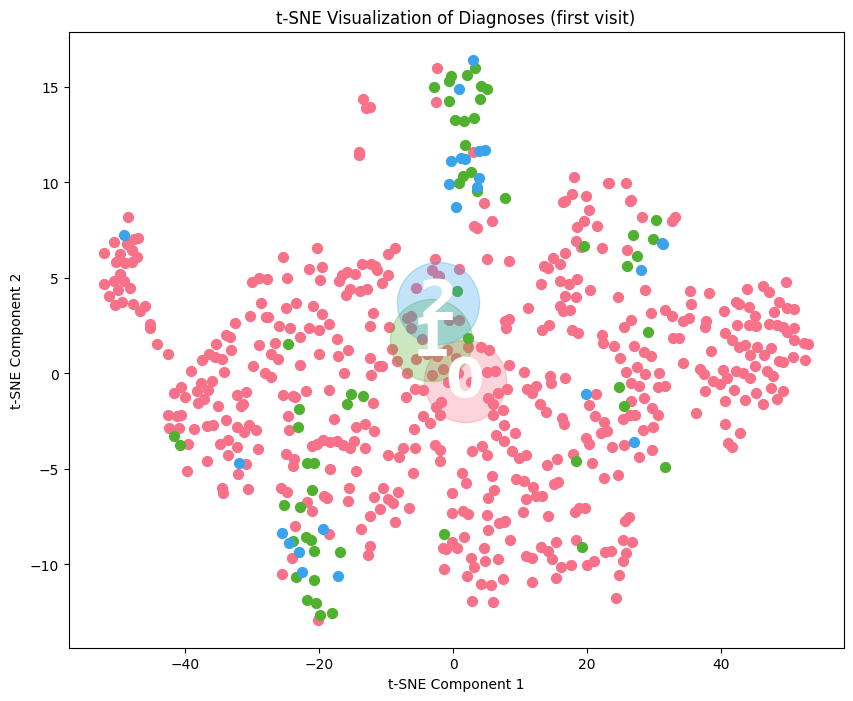

In [288]:
labels_nat = np.zeros(len(latent_scaled))
labels_nat[1326 : 1787]=1
labels_nat[1787 : 2000]=2
plot_clusters(latent_scaled[first_visit["imageid"]], labels_nat[first_visit["imageid"]], n_clusters=3,title='t-SNE Visualization of Diagnoses (first visit)')

Trying to explain the clustering behaviour we see using the clinical data about the subjects

In [284]:
first_visit = all_subjects.sort_values("imgDate").groupby("subject").first()

C:\Users\PieHu\AppData\Local\Temp\ipykernel_66012\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


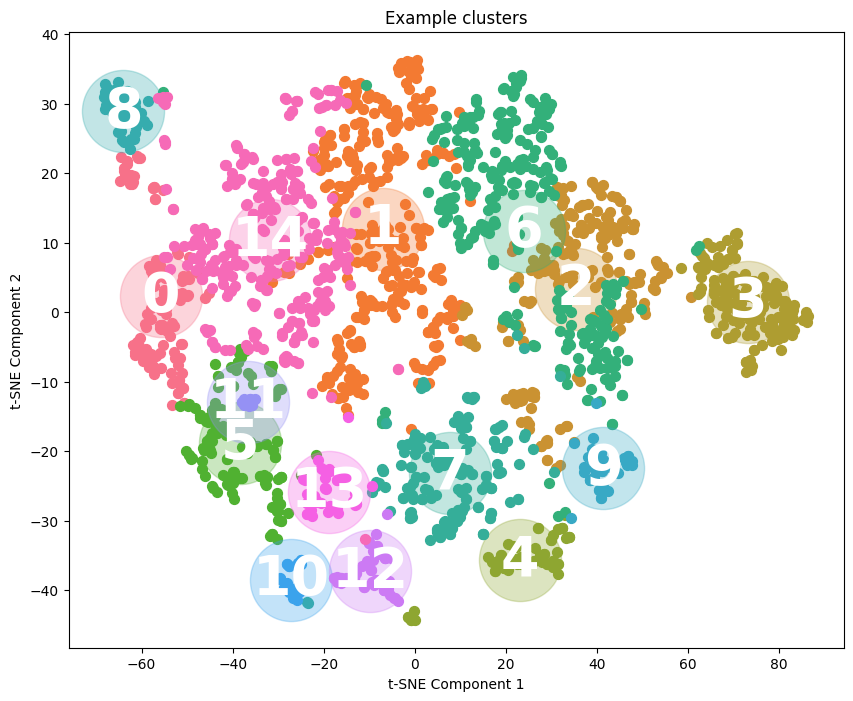

In [307]:
# latent_scaled = all_latent_scaled[0]
n_clusters = 15 # [first_visit["imageid"]]
labels, p_values_samples = find_clusters(latent_scaled, n_clusters=n_clusters)
plot_clusters(latent_scaled, labels, n_clusters=n_clusters,title='Example clusters')
import pandas as pd
all_subjects = pd.read_csv("Data/subjects_nan.csv").drop(columns="Unnamed: 0")
all_subjects["is_AD"] = all_subjects["Group"] == 2
all_subjects["is_MCI"] = all_subjects["Group"] == 1
X = all_subjects.drop(columns=["imageid","subject","Group", "is_AD","is_MCI"]).copy()
y = labels
all_subjects["cluster_id"] = labels

In [308]:
import pandas as pd
import scipy.stats as stats

# Assuming df_merged is the merged dataframe with ['subject', 'cluster_id', 'feature_1', ...]

clusters = all_subjects['cluster_id'].unique()
features = X.drop(columns="imgDate").columns

anova_results = []

for feature in features:
    # Extract feature values for all clusters
    if feature not in all_subjects: continue
    cluster_data = [all_subjects[all_subjects['cluster_id'] == c][feature] for c in clusters]
    
    # Perform one-way ANOVA
    f_stat, p_anova = stats.f_oneway(*cluster_data)
    
    anova_results.append({'feature': feature, 'p_anova': p_anova})

# Convert to DataFrame
df_anova_results = pd.DataFrame(anova_results)
important_features = df_anova_results[~pd.isna(df_anova_results["p_anova"])] # Since some features contain zero variance, we get NaN values
important_features[important_features["p_anova"]<0.01].sort_values(by="p_anova").reset_index(drop=True)

C:\Users\PieHu\AppData\Local\Temp\ipykernel_66012\1701796099.py:17: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_anova = stats.f_oneway(*cluster_data)


,feature,p_anova
0,MMSE,9.499600e-193
1,num_events,1.374428e-184
2,PTDOBYY,9.521723e-152
3,PXNECK,2.934185e-97
4,PTEDUCAT,5.247249e-65
5,PTGENDER,1.322378e-56
6,PXPERIPH,6.919260e-35
7,AEHCMEDS,1.038555e-31
8,PTHOME,5.605494e-18
9,AEHLUMB,6.520145e-18


Significant features to predict cluster: ``num_events``, ``AEHLUMB``, ``AERELPAN``, ``AEHCMEDS``, ``AESERIOUS``.

Features are gathered from , meaning that the mean of these features represent the expected number of events a subject experiences.

- ``num_events``: How many adverse events has subject X experienced?
- ``AEHLUMB``: Serious event related to lumbar puncture.
- ``AERELPAN``: Serious event related to COVID-19.
- ``AEHCMEDS``: Was medication needed?
- ``AESERIOUS``: Was event serious at any time during the trial?

In [309]:
print("Mean values for various clusters.")
all_subjects[["is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER"]].groupby(by="cluster_id").mean()

Mean values for various clusters.


,is_AD,is_MCI,PTCOGBEG,PTDOBYY,num_events,Namenda,PTGENDER
cluster_id,,,,,,,
0,0.041667,0.200000,9265.051020,1941.900000,5.833333,0.080392,1.416667
1,0.006079,0.082067,9384.221154,1943.765957,4.443769,0.014667,1.547112
2,0.039024,0.126829,9288.488889,1945.170732,5.253659,0.017081,1.629268
3,0.019608,0.013072,9944.700680,1947.372549,3.555556,0.000000,1.771242
4,0.090909,0.848485,5555.555556,1931.606061,13.833333,0.198961,1.151515
5,0.426471,0.419118,4388.596491,1928.301471,10.389706,0.337382,1.198529
6,0.047458,0.077966,9608.360902,1944.627119,3.983051,0.006207,1.691525
7,0.263158,0.567251,5345.880597,1934.520468,9.678363,0.365672,1.502924
8,0.040000,0.000000,9999.000000,1945.100000,2.600000,0.001894,1.700000


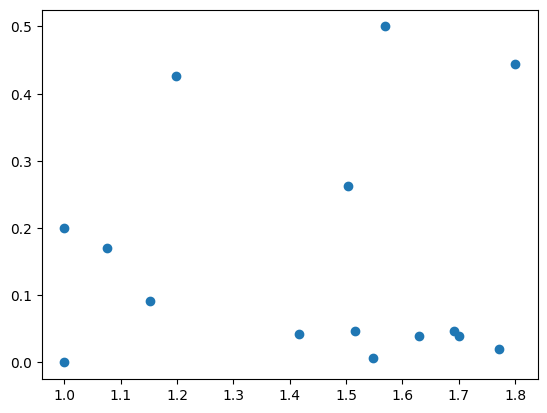

In [314]:
n=all_subjects[["is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER"]].groupby(by="cluster_id").mean()
plt.scatter(n["PTGENDER"],n["is_AD"])

AEHLUMB may be lower in the AD clusters because positive diagnosis stops further testing. Thus we get the case where the younger you get diagnosed with AD, the fewer tests you do in total.

MOTHAGE is lower in AD clusters because testing is biased; people suffering from AD may not remember their mothers age. Indeed we see this for a number of variables. The AD group has more missing values than the non-AD group:

In [139]:
valid_cols = []
for c in all_subjects:
    try:
        var = all_subjects.loc[all_subjects["Group"]!=0,c].var()
        if var == 0:
            print(c)
        else:
            valid_cols.append(c)
    except: pass
len(valid_cols)

AERELAD
AERELCM
AERELFLRBTBN
AERELFLRBPR
AEHIMG
AERELTAU
AERELNAV
AERELMK
AERELPI
AEHLUMB
AERELCOVID
AERELPAN
AERELATESP
Cognex
Num_siblings
MOTHAGE
FATHAGE
PXGENAPP
PXABDOM
PXOTHER
PXABNORM


97

In [140]:
valid_cols.append("Cognex")
all_subjects = all_subjects[valid_cols]

In [ ]:
all_subjects["age"] = all_subjects["first_mmse_year"] - all_subjects["PTDOBYY"]
age_AD = all_subjects.loc[all_subjects["Group"]==2,"age"].mean()
age_CN = all_subjects.loc[all_subjects["Group"]==0,"age"].mean()
print(f"{age_AD:.2f} - {age_CN:.2f} = {age_AD - age_CN:.2f}")

77.97 - 66.58 = 11.39


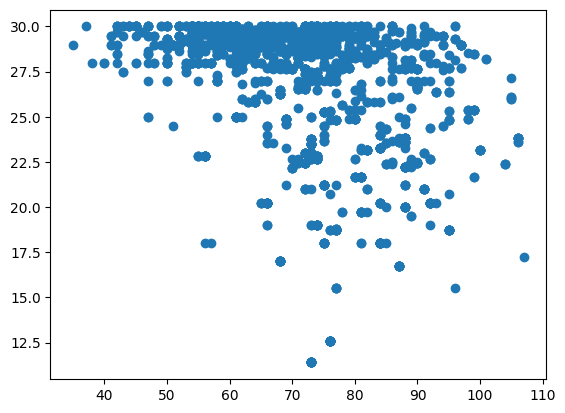

In [101]:
plt.scatter(all_subjects["first_mmse_year"]-all_subjects["PTDOBYY"], all_subjects["MMSE"])

In [249]:
all_subjects[["is_AD","PTGENDER","is_MCI","PTHOME"]].groupby(by=["PTGENDER","is_AD"]).mean()

is_MCI    PTHOME
PTGENDER is_AD                    
1.0      False  0.366589  1.379350
         True   0.000000  2.086420
2.0      False  0.156757  1.427027
         True   0.000000  1.689394

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming 'all_subjects' is your DataFrame

# Prepare the dataset
X = all_subjects[["PTGENDER", "PTHOME", "PTMARRY", "PTHAND", "PXPERIPH", "PXMUSCUL", "SIBDEMENT", "Anti-depressant", "PXEXTREM","PXSKIN"]]  # Features: all columns except 'is_AD'
mask = ~pd.isna(all_subjects["PXPERIPH"])
X= X[mask].fillna(0)
# X = X.dropna()#X.fillna(0)
y = all_subjects[['is_AD']]  # Target: 'is_AD'
y=y[mask].fillna(0)
X_scaled=StandardScaler().fit_transform(X)
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optional: To see the coefficients of each feature in the model
coefficients = pd.DataFrame(model.coef_.T, X.columns, columns=['Coefficient'])
coefficients


Mean Squared Error: 0.08520198206754781
R-squared: 0.1466468149729171


,Coefficient
PTGENDER,0.039616
PTHOME,0.028789
PTMARRY,-0.023564
PTHAND,-0.026892
PXPERIPH,0.050814
PXMUSCUL,0.012932
SIBDEMENT,-0.023903
Anti-depressant,-0.026269
PXEXTREM,-0.011692
PXSKIN,0.025587


In [215]:
all_subjects.loc[all_subjects["Group"]==2,"PTHAND"].mean()

1.0093896713615023